In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.applications import VGG16

# SEED = 55

# np.random.seed = SEED
# tf.random.set_seed(SEED)


In [2]:
train_dir = '/kaggle/input/100-bird-species/train'
val_dir = '/kaggle/input/100-bird-species/valid'
test_dir = '/kaggle/input/100-bird-species/test'

In [3]:
BS = 64
img_size = 224

In [4]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   )

val_datagen = ImageDataGenerator(rescale=1/255.)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(
                                                        img_size, img_size),
                                                    batch_size=BS,
                                                    shuffle=True,
                                                    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(val_dir,
                                                       target_size=(
                                                           img_size, img_size),
                                                       batch_size=BS,
                                                       shuffle=False,
                                                       class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(
                                                      img_size, img_size),
                                                  batch_size=BS,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 82724 images belonging to 515 classes.
Found 2575 images belonging to 515 classes.
Found 2575 images belonging to 515 classes.


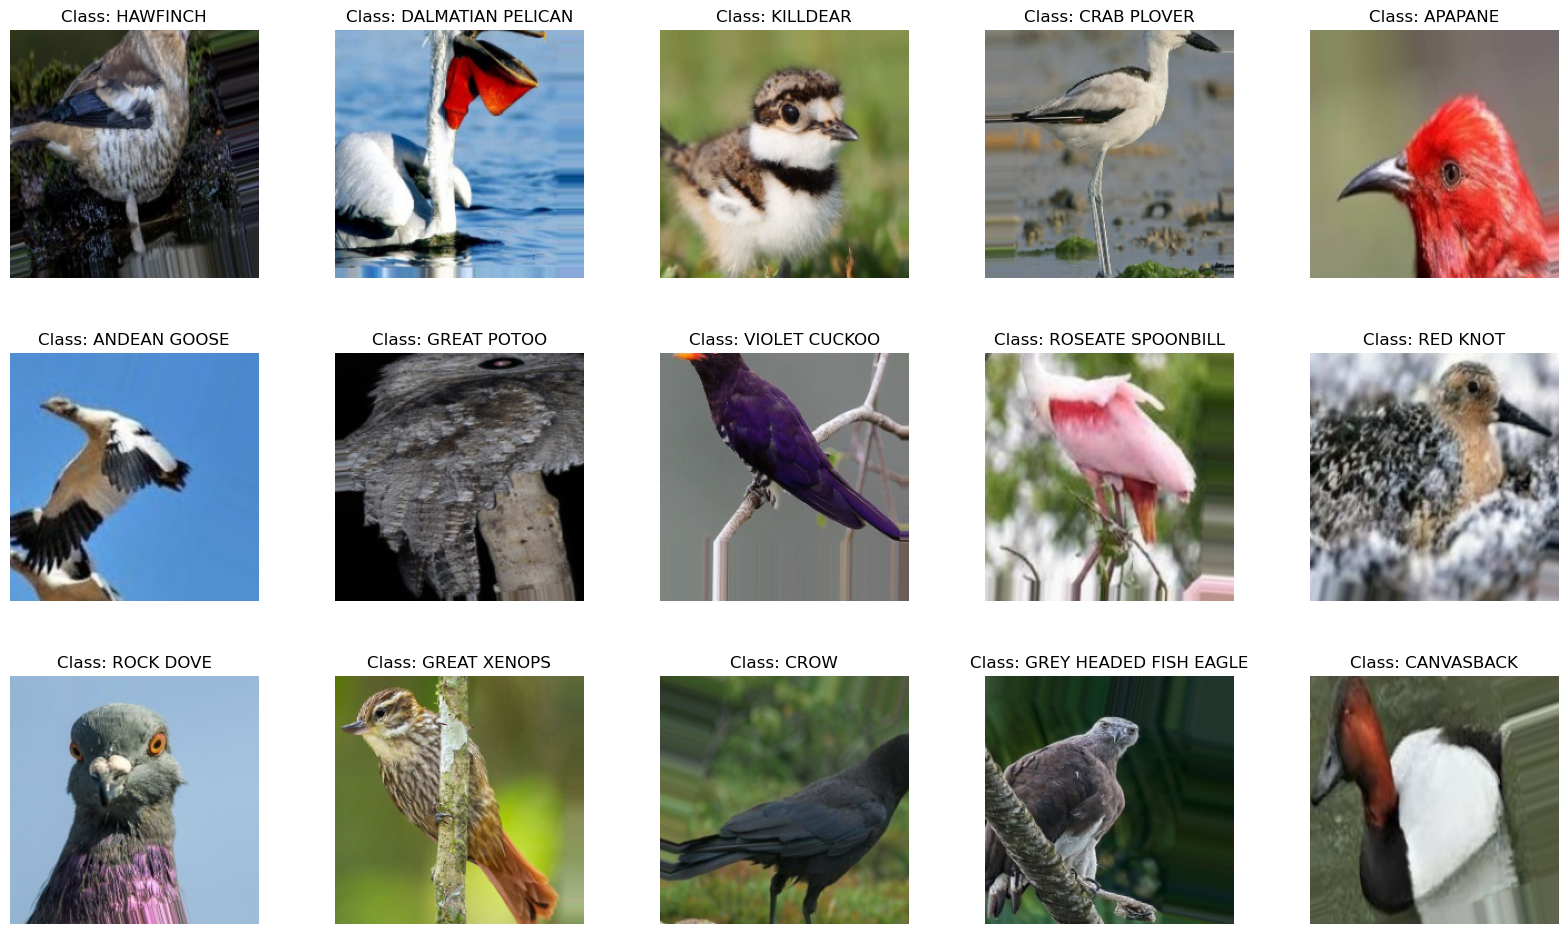

In [5]:
labels = [k for k in train_generator.class_indices]
sample_generate = train_generator.__next__()

images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i],axis=0)]}')
    plt.axis("off")

# Model without Trainable

In [6]:
from tensorflow.keras.applications.resnet import ResNet101
base_model = ResNet101(include_top = False,
                       weights = 'imagenet',
                       input_shape = (img_size,img_size,3))

for layer in base_model.layers:
    layer.trainable = False

171446536/171446536 [==============================] - 2s 0us/step


In [7]:
for layer in base_model.layers:
    sp = " ------------------->" [len(layer.name)-9:]
    print(layer.name, sp, layer.trainable)

input_1 -> False
conv1_pad  -------------------> False
conv1_conv -------------------> False
conv1_bn > False
conv1_relu -------------------> False
pool1_pad  -------------------> False
pool1_pool -------------------> False
conv2_block1_1_conv ----------> False
conv2_block1_1_bn ------------> False
conv2_block1_1_relu ----------> False
conv2_block1_2_conv ----------> False
conv2_block1_2_bn ------------> False
conv2_block1_2_relu ----------> False
conv2_block1_0_conv ----------> False
conv2_block1_3_conv ----------> False
conv2_block1_0_bn ------------> False
conv2_block1_3_bn ------------> False
conv2_block1_add -------------> False
conv2_block1_out -------------> False
conv2_block2_1_conv ----------> False
conv2_block2_1_bn ------------> False
conv2_block2_1_relu ----------> False
conv2_block2_2_conv ----------> False
conv2_block2_2_bn ------------> False
conv2_block2_2_relu ----------> False
conv2_block2_3_conv ----------> False
conv2_block2_3_bn ------------> False
conv2_block2_add

In [8]:
inputs = tf.keras.Input(shape=(img_size,img_size, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(515, activation='softmax')(x)

model = tf.keras.Model(inputs, output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                             

In [9]:
def modelDetails(history, name):
    plt.figure(figsize=(10,4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(name + ' Loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['Train','Val'], loc= 'upper left')
    plt.show()
    
    plt.figure(figsize=(10,3))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(name + ' Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [10]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(train_generator,
                    epochs=5,
                    verbose=1,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(validation_generator),
                    validation_data=validation_generator, 
                    use_multiprocessing=True,
                    workers=2,)

Epoch 1/5
1293/1293 [==============================] - 1225s 934ms/step - loss: 6.2465 - accuracy: 0.0021 - val_loss: 6.2420 - val_accuracy: 0.0016
Epoch 2/5
1293/1293 [==============================] - 1054s 812ms/step - loss: 6.2264 - accuracy: 0.0034 - val_loss: 6.1839 - val_accuracy: 0.0039
Epoch 3/5
1293/1293 [==============================] - 1080s 832ms/step - loss: 6.1772 - accuracy: 0.0045 - val_loss: 6.1407 - val_accuracy: 0.0043
Epoch 4/5
1293/1293 [==============================] - 1035s 800ms/step - loss: 6.1560 - accuracy: 0.0047 - val_loss: 6.1239 - val_accuracy: 0.0035
Epoch 5/5
1293/1293 [==============================] - 1071s 825ms/step - loss: 6.1452 - accuracy: 0.0046 - val_loss: 6.1038 - val_accuracy: 0.0047


In [11]:
results1 = model.evaluate(test_generator)

41/41 [==============================] - 25s 603ms/step - loss: 6.0946 - accuracy: 0.0058


# Model with Tranable

In [12]:
base_model2 = ResNet101(include_top = True,
                       weights = 'imagenet',
                       input_shape = (img_size,img_size,3))


179648224/179648224 [==============================] - 3s 0us/step


In [13]:
for layer in base_model2.layers[:-2]:
    layer.trainable = True


for layer in base_model2.layers:
    sp = " ------------------->" [len(layer.name)-9:]
    print(layer.name, sp, layer.trainable)

input_3 -> True
conv1_pad  -------------------> True
conv1_conv -------------------> True
conv1_bn > True
conv1_relu -------------------> True
pool1_pad  -------------------> True
pool1_pool -------------------> True
conv2_block1_1_conv ----------> True
conv2_block1_1_bn ------------> True
conv2_block1_1_relu ----------> True
conv2_block1_2_conv ----------> True
conv2_block1_2_bn ------------> True
conv2_block1_2_relu ----------> True
conv2_block1_0_conv ----------> True
conv2_block1_3_conv ----------> True
conv2_block1_0_bn ------------> True
conv2_block1_3_bn ------------> True
conv2_block1_add -------------> True
conv2_block1_out -------------> True
conv2_block2_1_conv ----------> True
conv2_block2_1_bn ------------> True
conv2_block2_1_relu ----------> True
conv2_block2_2_conv ----------> True
conv2_block2_2_bn ------------> True
conv2_block2_2_relu ----------> True
conv2_block2_3_conv ----------> True
conv2_block2_3_bn ------------> True
conv2_block2_add -------------> True
conv2_

In [14]:
# base_model2.summary()

In [15]:
from tensorflow.keras.models import Model
newmodel = Model(base_model2.input, outputs= base_model2.layers[-2].output)

In [16]:
newmodel.output.name

'avg_pool/Mean:0'

In [17]:
inputs = tf.keras.Input(shape=(img_size,img_size, 3))
x = newmodel(inputs)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(515, activation='softmax')(x)

model2 = tf.keras.Model(inputs, output)
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 model_1 (Functional)        (None, 2048)              42658176  
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               3289

In [18]:
model2.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

history2 = model2.fit(train_generator,
                      epochs=5,
                      verbose=1, 
                      steps_per_epoch=len(train_generator),
                      validation_steps=len(validation_generator),
                      validation_data=validation_generator, 
                      use_multiprocessing=True, 
                      workers=2,)

Epoch 1/5
1293/1293 [==============================] - 1346s 985ms/step - loss: 4.2597 - accuracy: 0.2053 - val_loss: 1.4357 - val_accuracy: 0.6765
Epoch 2/5
1293/1293 [==============================] - 1244s 961ms/step - loss: 1.5697 - accuracy: 0.6328 - val_loss: 0.4982 - val_accuracy: 0.8816
Epoch 3/5
1293/1293 [==============================] - 1271s 981ms/step - loss: 0.9526 - accuracy: 0.7735 - val_loss: 0.4122 - val_accuracy: 0.8990
Epoch 4/5
1293/1293 [==============================] - 1340s 1s/step - loss: 0.7085 - accuracy: 0.8308 - val_loss: 0.3550 - val_accuracy: 0.9099
Epoch 5/5
1293/1293 [==============================] - 1319s 1s/step - loss: 0.5859 - accuracy: 0.8594 - val_loss: 0.2867 - val_accuracy: 0.9282


In [19]:
results2 = model2.evaluate(test_generator)

41/41 [==============================] - 12s 300ms/step - loss: 0.1927 - accuracy: 0.9429


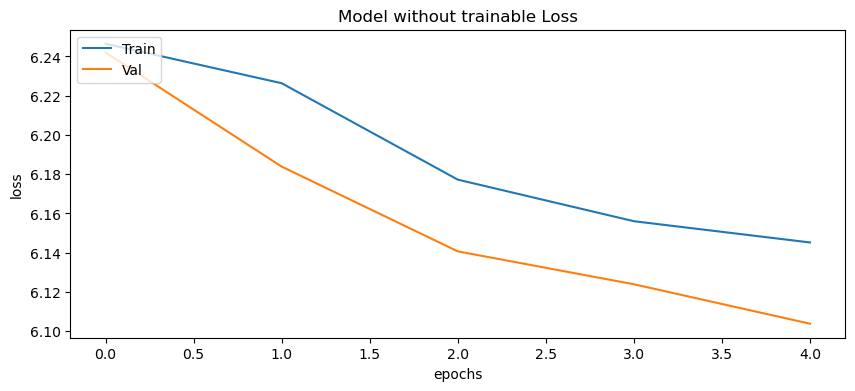

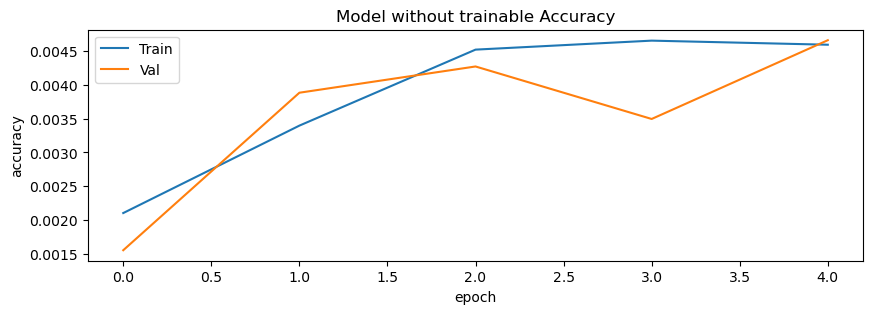

In [20]:
modelDetails(history, 'Model without trainable')

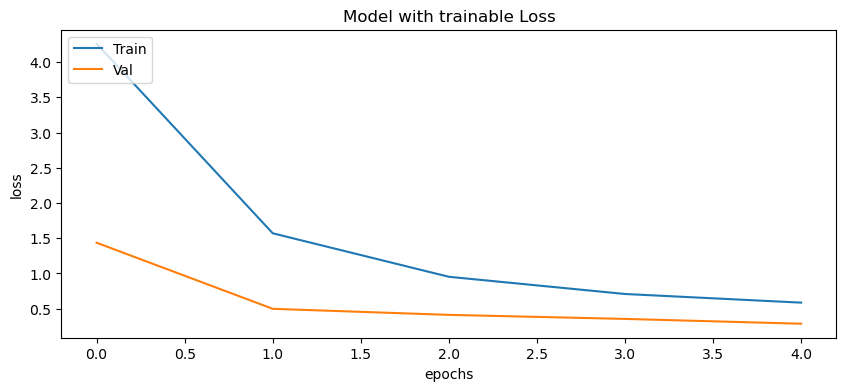

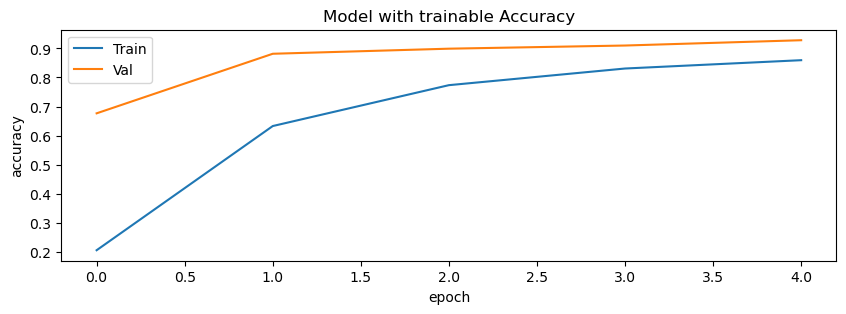

In [21]:
modelDetails(history2, 'Model with trainable')